Introducción a las Redes Neuronales para Análisis de Textos, 2024



---
# Ejercicio: Uso de Word Embeddings en un clasificador

En este notebook se explorará una colección de word embeddings preentrenada y se la utilizará para entrenar un clasificador de detección de humor.


---



Descargar una colección de embeddings.

En este ejercicio se pueden utilizar diferentes colecciones de embeddings, que darán distintos resultados. Proveemos tres alternativas, cada una con sus pros y sus contras.

1.   Embeddings del Spanish Billion Word Corpus (SBWCE): tamaño 300, están entrenados con más de mil millones de palabras en español y se cargan con gensim.
2.   Embeddings de Wikipedia en HuggingFace: tamaño 100, están entrenados con el texto de la Wikipedia en español (mucho menos texto) y se cargan con gensim.
3.   Embeddings tipo FastText de TorchNLP: tamaño 300, son otro tipo de vector distinto a word2vec, no podemos utilizar gensim por lo que hay que implementar métodos particulares para los cálculos de similitud.



In [3]:
# Alternativa 1

# Fromas de bajar los embeddings de SBWC:

# Sitio oficial de la Universidad Nacional de Córdoba
# ! wget https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz

# Mirror en el Owncloud de Fing
! wget https://www.fing.edu.uy/owncloud/index.php/s/ryHF9xWwox3NrFe/download/SBW-vectors-300-min5.bin.gz

# Si los enlaces son demasiado lentos: bajarlo una sola vez y copiarlo a google drive
# ! cp /content/drive/MyDrive/share/SBW-vectors-300-min5.bin.gz .

# El archivo viene en un gzip, lo descomprimimos
! gzip -d SBW-vectors-300-min5.bin.gz

# Abrirlos con la biblioteca de embeddings gensim
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format("./SBW-vectors-300-min5.bin", binary=True)
print(wv.vectors.shape)
embeddings_size = wv.vectors.shape[1]



7[Files: 0  Bytes: 0  [0 B/s] Re]87[https://www.fing.edu.uy/ownclo]87SBW-vectors-300-min5   0% [>                             ]    6.75K    --.-KB/s87SBW-vectors-300-min5   0% [>                             ]    1.32M   10.57MB/s87SBW-vectors-300-min5   0% [>                             ]    4.22M   16.87MB/s87SBW-vectors-300-min5   0% [>                             ]    7.62M   20.31MB/s87SBW-vectors-300-min5   1% [>                             ]   10.74M   21.48MB/s87SBW-vectors-300-min5   1% [>                             ]   13.57M   21.67MB/s87SBW-vectors-300-min5   1% [>                             ]   17.29M   23.02MB/s87SBW-vectors-300-min5   1% [>                             ]   20.76M   23.69MB/s87SBW-vectors-300-min5   2% [>                             ]   24.48M   24.45MB/s87SBW-vectors-300-min5   2% [>                             ]   27.70M   24.57MB/s87SBW-vectors-300-min5   2% [>                             ]   30.50M   24.35MB/s87SBW-vectors

Probar algunos casos simples de interés.

¿Cómo son los vectores de palabras contenidos en esta colección?

¿Qué otras palabras hay cerca de una palabra objetivo?

In [6]:
# print(wv['perro'])
print(wv.most_similar('perro'))

[('perros', 0.7533276677131653), ('cachorro', 0.753067135810852), ('gato', 0.7445881366729736), ('schnauzer', 0.7370451092720032), ('mastín', 0.7347642779350281), ('caniche', 0.7329744696617126), ('teckel', 0.7326836585998535), ('pinscher', 0.7305285930633545), ('collie', 0.7226554155349731), ('bulldog', 0.7155663967132568)]


Probar algunas analogías, utilizando el método most_similar() de gensim:

rey - hombre + mujer ≈ reina

parís - francia + uruguay ≈ montevideo

Buscar por lo menos cuatro ejemplos más de analogías.

In [35]:

# Ejempo 1: desayuno - mañana + noche ≈ tarde
result = wv.most_similar(positive=['desayuno', 'noche'], negative=['mañana'], topn=1)
print("desayuno - mañana + noche ≈", result[0][0])

# Ejempo 2: invierno - frío + calor ≈ verano
result = wv.most_similar(positive=['invierno', 'calor'], negative=['frío'], topn=1)
print("invierno - frío + calor ≈", result[0][0])

# Ejempo 3: doctor - hombre + mujer ≈ doctora
result = wv.most_similar(positive=['doctor', 'mujer'], negative=['hombre'], topn=1)
print("doctor - hombre + mujer ≈", result[0][0])

# Ejemplo 4: día - sol + luna ≈ noche
result = wv.most_similar(positive=['día', 'luna'], negative=['sol'], topn=1)
print("día - sol + luna ≈", result[0][0])

desayuno - mañana + noche ≈ cena
invierno - frío + calor ≈ verano
doctor - hombre + mujer ≈ doctora
día - sol + luna ≈ noche


Probar algunas similitudes entre palabras utilizando el método similarity() de gensim

Considere los pares:

*   perro - gato
*   frío - helado
*   democracia - monarquía
*   frío - caliente

Escribir por lo menos seis pares más.

¿Cuáles deberían estar más cerca según la intuición humana?

¿Se cumple eso en los embeddings?

In [36]:
# cálculo de similitud
similarity_pairs = [
    ('sol', 'luna'),
    ('mar', 'océano'),
    ('cielo', 'nube'),
    ('amor', 'odio'),
    ('ciudad', 'pueblo'),
    ('libro', 'revista')
]

for word1, word2 in similarity_pairs:
    sim = wv.similarity(word1, word2)
    print(f"Similityd entre {word1} y {word2}: {sim:.4f}")


Similarity between sol and luna: 0.5805
Similarity between mar and océano: 0.7095
Similarity between cielo and nube: 0.4407
Similarity between amor and odio: 0.5730
Similarity between ciudad and pueblo: 0.6191
Similarity between libro and revista: 0.4494


R:  Los embeddings parecen capturar bien algunas relaciones intuitivas, como mar - océano y ciudad - pueblo. Pero la similitud entre amor - odio es más alta de lo esperado teniendo en cuenta que son antonimos, lo que sugiere que los embeddings están capturando una relación de contexto o intensidad emocional.

Probar el cálculo de distancia con el método distance() de gensim. ¿Cuál es la relación con el método usado en la parte anterior?

In [39]:
for word1, word2 in similarity_pairs:
    dist = wv.distance(word1, word2)
    print(f"Distancia entre {word1} y {word2}: {dist:.4f}")


Distancia entre sol y luna: 0.4195
Distancia entre mar y océano: 0.2905
Distancia entre cielo y nube: 0.5593
Distancia entre amor y odio: 0.4270
Distancia entre ciudad y pueblo: 0.3809
Distancia entre libro y revista: 0.5506


R: Como se puede observar, los pares con alta similitud tienen baja distancia y viceversa. Esto es consistente con la relación matemática entre similitud (basada en el [coseno del ángulo entre vectores](https://pytorch.org/docs/stable/generated/torch.nn.CosineSimilarity.html)) y distancia (calculada como 1 - similitud).

Visualizar con dos técnicas de reducción de dimensionalidad: PCA y t-SNE

Probaremos con un conjunto particular de palabras de distintas clases.

Realice más pruebas utilizando otras palabras que le parezcan relevantes.

In [43]:
import matplotlib.pyplot as plt
import numpy as np

words = [
    'perro', 'gato', 'elefante', 'tiburón', 'loro', 'paloma', 'ballena',
    'democracia', 'trabajo', 'economía', 'política', 'guerra',
    'aerodinámico', 'rápido', 'lento', 'intenso', 'furioso',
    'azul', 'rojo', 'verde', 'amarillo', 'naranja',
    'lunes', 'martes', 'domingo', 'febrero', 'diciembre',
    'comer', 'saltar', 'dormir', 'volar', 'salir', 'entrar',
    'coche', 'bicicleta', 'avión', 'tren', 'barco',
    'feliz', 'triste', 'enojado', 'sorprendido', 'asustado',
    'casa', 'edificio', 'puente', 'carretera', 'parque',
    'manzana', 'banana', 'uva', 'naranja', 'fresa'
]
X = np.array([wv[w] for w in words])

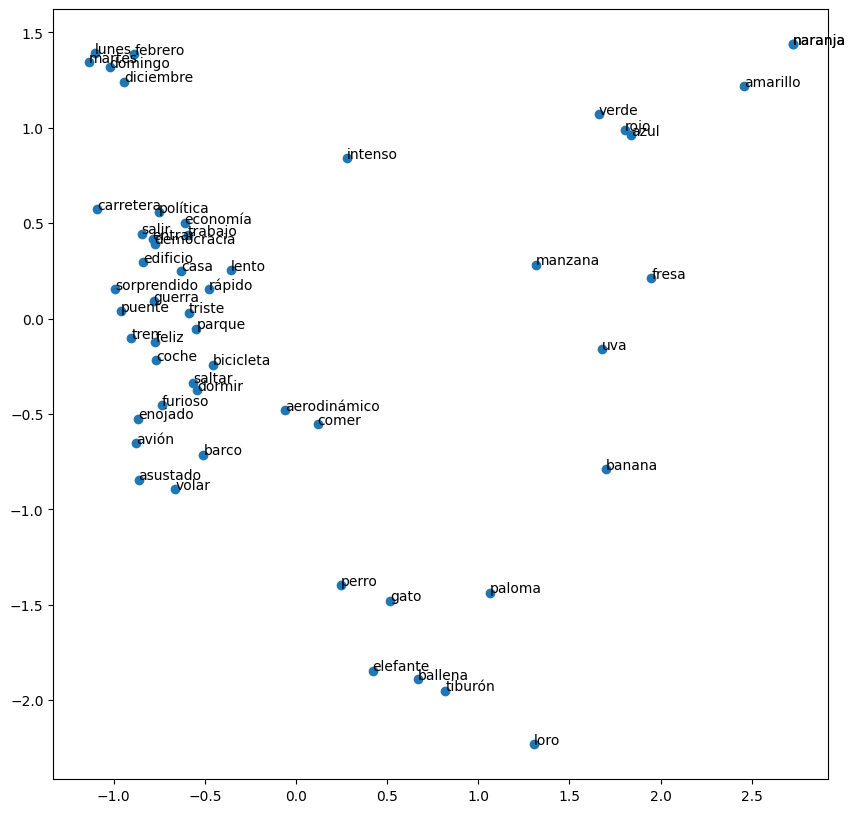

In [44]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_pca[:,0], X_pca[:,1])

for i, w in enumerate(words):
    ax.annotate(w, X_pca[i])

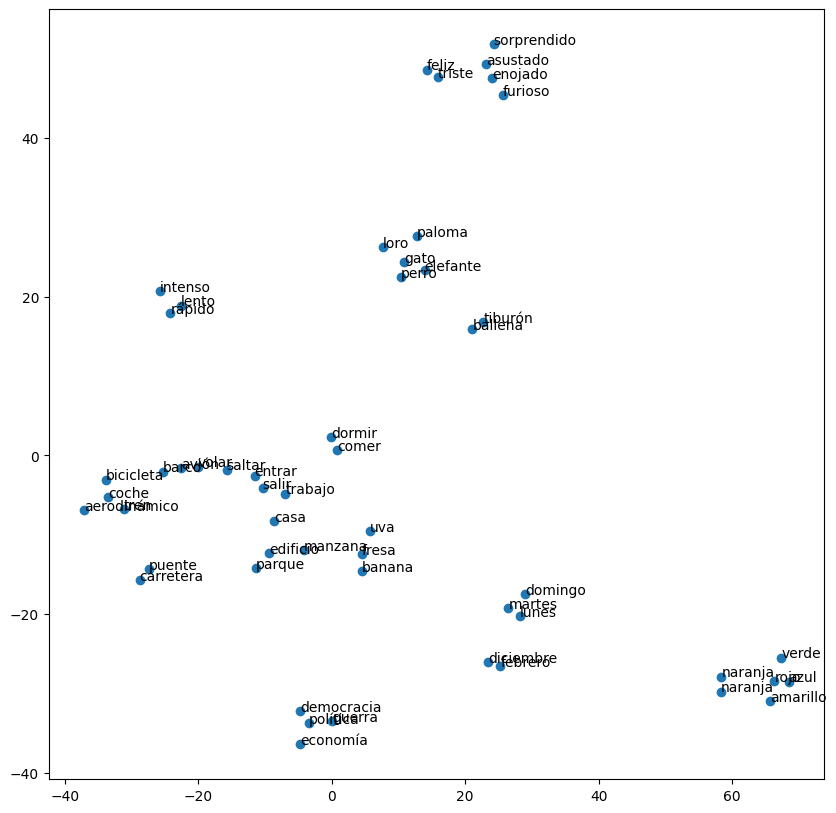

In [45]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_tsne[:,0], X_tsne[:,1])

for i, w in enumerate(words):
    ax.annotate(w, X_tsne[i])


Obtener y cargar el corpus de detección de humor. Este corpus tiene varias columnas, y fue utilizado en la competencia [HAHA 2021](https://www.fing.edu.uy/inco/grupos/pln/haha/). Las que nos interesarán en este ejercicio son las columnas `text` que contiene el texto del tweet, y la columna `is_humor` que indica si el tweet es un chiste o no.

In [46]:
! wget https://www.fing.edu.uy/owncloud/index.php/s/PJHnZ3rKe34mqc9/download/haha_2021.zip
! unzip haha_2021.zip



7[Files: 0  Bytes: 0  [0 B/s] Re]87[https://www.fing.edu.uy/ownclo]87haha_2021.zip         44% [============>                 ]  752.00K    --.-KB/s87haha_2021.zip        100% [=============================>]    1.63M   20.55MB/s87[Files: 1  Bytes: 1.63M [1.25MB]8Archive:  haha_2021.zip
  inflating: haha_2021_dev_gold.csv  
  inflating: haha_2021_test_gold.csv  
  inflating: haha_2021_train.csv     


In [48]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

train_df = pd.read_csv('./haha_2021_train.csv')
dev_df = pd.read_csv('./haha_2021_dev_gold.csv')
test_df = pd.read_csv('./haha_2021_test_gold.csv')
train_df.sample(5)


,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,humor_rating,humor_mechanism,humor_target
11512,tweet11513,Si a mí se me escapa un like stalkeando lo dej...,1,3,3,2,1,0,0,1.666667,NaN,NaN
15282,tweet15283,"—Hola\n\n—Ayy hola, oye ando en la calle y sol...",1,2,1,0,1,1,0,2.666700,NaN,NaN
16247,tweet16248,"Si Champions queremos ver, teneis que comenzar...",0,4,1,0,0,0,0,NaN,NaN,NaN
14064,tweet14065,Es normal si un Uke se viste de mujer de vez e...,0,3,2,0,0,0,0,NaN,NaN,NaN
2234,tweet2235,Como en serio hay algo que siempre te hace vol...,0,3,0,0,0,0,0,NaN,NaN,NaN


Para utilizar los textos del corpus en un clasificador, debemos realizar las siguientes acciones:

1.   Preprocesar los textos (p.e. tokenizar)
2.   Transformarlos a una representación vectorial (p.e. centroide)
3.   Obtener los labels del corpus (que son valores 0 o 1) como array de numpy.


In [49]:
import re

# tokenizador basico
def tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

train_tokens = [tokenize(t) for t in train_df.loc[:, 'text']]
dev_tokens = [tokenize(t) for t in dev_df.loc[:, 'text']]
test_tokens = [tokenize(t) for t in test_df.loc[:, 'text']]

In [51]:
def get_matrix(tokens):
    embeddings = []
    for tweet_tokens in tokens:
        tweet_embeddings = []
        for token in tweet_tokens:
            if token in wv:
                tweet_embeddings.append(wv[token])
        if tweet_embeddings:
            tweet_embedding = np.mean(tweet_embeddings, axis=0)  # promedio de los embeddings
        else:
            tweet_embedding = np.zeros(embeddings_size)
        embeddings.append(tweet_embedding)
    return np.array(embeddings)

train_v = get_matrix(train_tokens)
dev_v = get_matrix(dev_tokens)
test_v = get_matrix(test_tokens)

print(train_v.shape)
print(dev_v.shape)
print(test_v.shape)

(24000, 300)
(6000, 300)
(6000, 300)


In [52]:

train_labels = np.array(train_df.loc[:,'is_humor'])
dev_labels = np.array(dev_df.loc[:,'is_humor'])
test_labels = np.array(test_df.loc[:,'is_humor'])

print("train",np.bincount(train_labels))
print("dev",np.bincount(dev_labels))
print("test",np.bincount(test_labels))


train [14747  9253]
dev [3658 2342]
test [3000 3000]


El siguiente código es un script de evaluación muy simple que toma un clasificador, un conjunto de datos y sus labels esperados, y nos devuelve Precisión, Recall, F1 y Accuracy.

Utilizaremos este script de evaluación para comparar todos nuestros resultados.


In [53]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate(clf,vectors,labels):
  pred = clf.predict(vectors)
  p,r,f,s = precision_recall_fscore_support(labels,pred)
  a = accuracy_score(labels,pred)
  print("P %s, R %s, F %s, A %s" % (p[1],r[1],f[1],a))


Entrenar clasificadores en sklearn intentando encontrar el mejor para los datos de dev. Por ejemplo: LogisticRegression, RandomForestClassifier, SVC.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create and train the classifier
clf1 = LogisticRegression(random_state=42, max_iter=1000)
clf1.fit(train_v, train_labels)

# Evaluate on dev set
print("Dev set performance:")
evaluate(clf1, dev_v, dev_labels)

# Optionally, evaluate on training set
print("Training set performance:")
evaluate(clf1, train_v, train_labels)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest classifier with adjusted parameters
clf2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Limit the depth of the trees
    min_samples_split=5,  # Increase minimum samples required to split an internal node
    min_samples_leaf=2,  # Increase minimum samples required to be at a leaf node
    max_features='sqrt',  # Use sqrt(n_features) features in each tree
    random_state=42
)
clf2.fit(train_v, train_labels)

# Evaluate on training set
print("Random Forest - Training set performance:")
evaluate(clf2, train_v, train_labels)

# Evaluate on dev set
print("Random Forest - Dev set performance:")
evaluate(clf2, dev_v, dev_labels)

# Compare with the Logistic Regression classifier
print("\nComparison:")
print("LogisticRegression - Training set performance:")
evaluate(clf1, train_v, train_labels)
print("LogisticRegression - Dev set performance:")
evaluate(clf1, dev_v, dev_labels)


Evaluar sobre el conjunto de test la performance del mejor clasificador encontrado

In [ ]:
# %% [markdown]
# Evaluar sobre el conjunto de test la performance del mejor clasificador encontrado

# %%
clf_best = clf1  # Logistic Regression classifier
print("Best classifier (Logistic Regression) performance on test set:")
evaluate(clf_best, test_v, test_labels)